In [81]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.model import TCN
import numpy as np
import random

In [82]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.FashionMNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.FashionMNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

In [83]:
def trainTCN(epoch):
    global steps
    train_loss = 0
    model.train()
    mult = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, input_channels, seq_length)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if parameters['clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['clip'])
        optimizer.step()
        train_loss += loss.item()
#         train_losses_[epoch-1][mult*batch_indx + batch_indx] += train_loss
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                epoch, batch_idx * parameters['batch_size'], len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss/log_interval, steps))
            train_losses_[epoch-1].append(train_loss/log_interval)
            train_loss = 0  

In [84]:
def testTCN():
    test_loss = 0
    correct = 0
    correct_class = list(0. for i in range(10))
    correct_total = list(0. for i in range(10))
#     conf_matrix = [[] for i in range(len(classes))]
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.to(device), target.to(device)
            data = data.view(-1, input_channels, seq_length)
            if permutee:
                data = data[:, :, permute]
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(pred), pred.shape)
            c = (pred == target).squeeze()
            
#             tot += 1
            
#             if tot != 313:
#             for i in range(len(test_loader.dataset) // batch_size):
# #                     print(pred[i], target.data.view_as(pred)[i])
#                 print(i)
#                 label = pred[i]
#                 if (pred[i] == target.data.view_as(pred)[i]):
#                     correct_class[label] += c[i].item()
#                 correct_total[label] += 1
                    
                
#     print(tot)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
#     print(correct.item())
    accuracies_.append(correct.item() / 10000.)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [85]:
import pickle

def count_parameters(model=None, p=None):
    if model is not None:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    if p is not None:
        model = TCN(hidden_units=p['nhid'], levels=p['levels'], kernel_size=p['ksize'], 
                    dropout=p['dropout'])
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
        

# Print model's state_dict
def models_state_dict(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
def optimizers_state_dict():
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])

def save_obj(obj, name):
    with open('{0}.pkl'.format(name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('{0}.pkl'.format(name), 'rb') as f:
        return pickle.load(f)

In [86]:
def set_parameters(num_models=50, batch_size=[32, 64, 128], dropout=[0., 1],
                  clip=[0.3, 1.], lr=[-6, 1], ksize=[3, 8], levels=[3, 9],
                  optim='Adam', nhid=[15, 30], epochs=[1, 6]):

    seen_hyper = set()
    list_parameters = [{} for i in range(0, num_models)]
    for i in range(0, num_models):
        while(True):
            list_parameters[i]['batch_size'] = random.choice(batch_size)
            list_parameters[i]['dropout'] = np.random.uniform(dropout[0], dropout[1])
            list_parameters[i]['clip'] = np.random.uniform(clip[0], clip[1])
            list_parameters[i]['lr'] = pow(10, np.random.uniform(lr[0], lr[1]))
            list_parameters[i]['ksize'] = np.random.randint(ksize[0], ksize[1])
            list_parameters[i]['levels'] = np.random.randint(levels[0], levels[1])
            list_parameters[i]['optim'] = optim
            list_parameters[i]['nhid'] = np.random.randint(nhid[0], nhid[1])
            list_parameters[i]['epochs'] = np.random.randint(epochs[0], epochs[1])
            k = "".join(str(v) + '_' for k, v in list_parameters[i].items())
            if k not in seen_hyper:
                seen_hyper.add(k)
                break
    return list_parameters
# save_obj(list_parameters, 'list_parameters')
# [param for param in list_parameters]

In [87]:
def show_models_results(scores, list_params):
    for i, score in enumerate(scores):
        print("Model {0}".format(list_params[i]['id']))
        print("Parameters => {0}".format(list_params[i]))
        print("Model size => {}".format(count_parameters(None, list_params[i])))
        print("Inference accuracy => {0}".format(score['accuracies'][-1]))
#         print("Train losses => {0}".format([losses for losses in score['train_losses']]))
#         print("Test losses => {0}".format([losses for losses in score['test_losses']]))    

In [88]:
import matplotlib.pyplot as plt

def plotTrainLosses(scores = [], fsize = 18, xlabel = '', ylabel = '', 
                    title = '', axis = [0, 5, 0, 3], p=None):
    fig, ax = plt.subplots(figsize=(fsize, fsize))

    for i, score in enumerate(scores):
        idx = -1
        if p is not None:
            idx = p[i]['id']
        else:
            idx = i + 1
#         all_losses = [sum(losses)/len(score['train_losses']) for losses in score['train_losses']]
        ax.plot(score['train_losses'], label="TCN {0}".format(idx))
#         print(all_losses)

    legend = ax.legend()
    legend.get_frame().set_facecolor('C0')
    plt.axis(axis)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [89]:
def plotAccuracies(scores, fsize=7, acc_score=.20, xlabel='epochs', 
                    ylabel='inference accuracy', axis=[1, 5, 0, 1],
                    title='', p=None):
    
    fig, ax = plt.subplots(figsize=(fsize, fsize))

    for i, score in enumerate(scores):
        if score['accuracies'][-1] >= acc_score:
            if p is not None:
                indx = p[i]['id']
            else:
                indx = i + 1
            ax.plot([s for s in score['accuracies']], label="TCN {0}".format(indx))

    legend = ax.legend()
    legend.get_frame().set_facecolor('C0')
    plt.axis(axis)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [90]:
# load scores object
scores = load_obj('scores')
# fix old train_losses format
for i, score in enumerate(scores):
    score['train_losses'] = [s[0][0] for s in score['train_losses']]
first_parameters = load_obj('list_parameters')
first_parameters
for i, p in enumerate(first_parameters):
    p['id'] = i + 1
show_models_results(scores, first_parameters)

Model 1
Parameters => {'batch_size': 32, 'dropout': 0.34326058921300817, 'clip': 0.6493645456943744, 'lr': 0.005133514861863708, 'ksize': 5, 'levels': 4, 'optim': 'Adam', 'nhid': 19, 'epochs': 3, 'id': 1}
Model size => 13272
Inference accuracy => 0.5382
Model 2
Parameters => {'batch_size': 128, 'dropout': 0.3204702118301702, 'clip': 0.3579083284985158, 'lr': 1.0185733259129417, 'ksize': 4, 'levels': 6, 'optim': 'Adam', 'nhid': 22, 'epochs': 3, 'id': 2}
Model size => 22186
Inference accuracy => 0.1
Model 3
Parameters => {'batch_size': 16, 'dropout': 0.9286488118988279, 'clip': 0.5197077677943913, 'lr': 0.007293870963106499, 'ksize': 6, 'levels': 7, 'optim': 'Adam', 'nhid': 17, 'epochs': 5, 'id': 3}
Model size => 23334
Inference accuracy => 0.1258
Model 4
Parameters => {'batch_size': 32, 'dropout': 0.37918178078672027, 'clip': 0.651728735624619, 'lr': 2.035863843405201e-06, 'ksize': 3, 'levels': 3, 'optim': 'Adam', 'nhid': 25, 'epochs': 1, 'id': 4}
Model size => 10060
Inference accuracy 

Model size => 21010
Inference accuracy => 0.1012
Model 50
Parameters => {'batch_size': 32, 'dropout': 0.4508579955655422, 'clip': 0.6191527335360922, 'lr': 0.00038510427529878436, 'ksize': 4, 'levels': 7, 'optim': 'Adam', 'nhid': 23, 'epochs': 4, 'id': 50}
Model size => 28530
Inference accuracy => 0.7005


### Train Losses

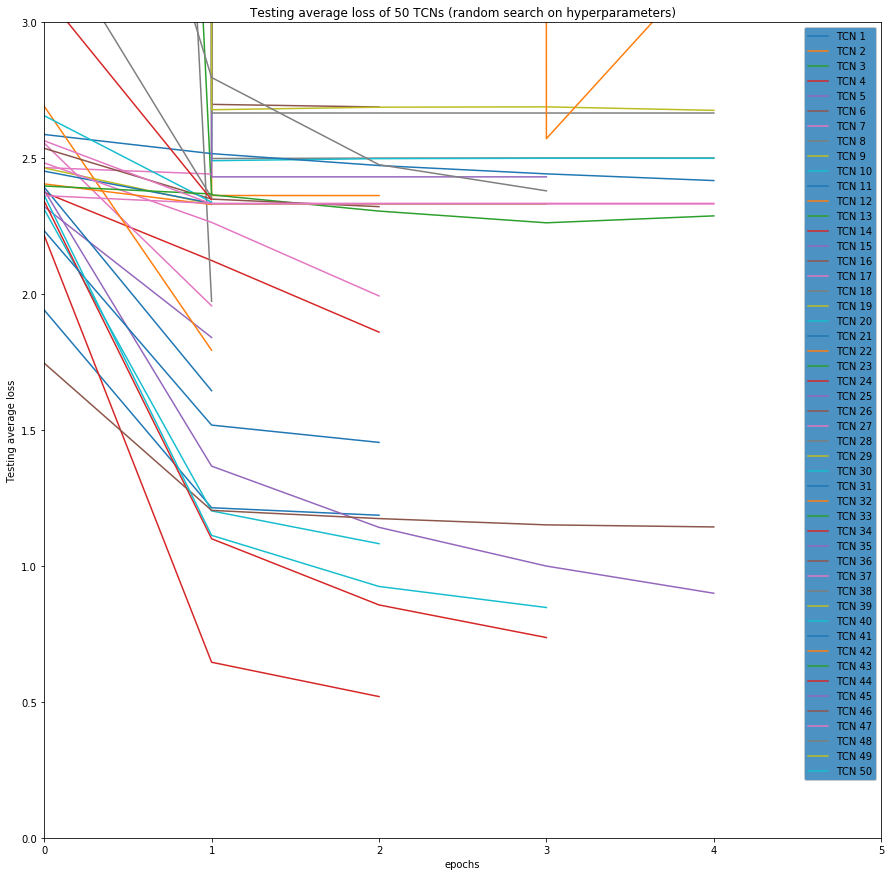

In [91]:
plotTrainLosses(scores, fsize=15, xlabel='epochs', ylabel='Testing average loss', 
                title='Testing average loss of 50 TCNs (random search on hyperparameters)',
               axis=[0, 5, 0, 3], p=first_parameters)

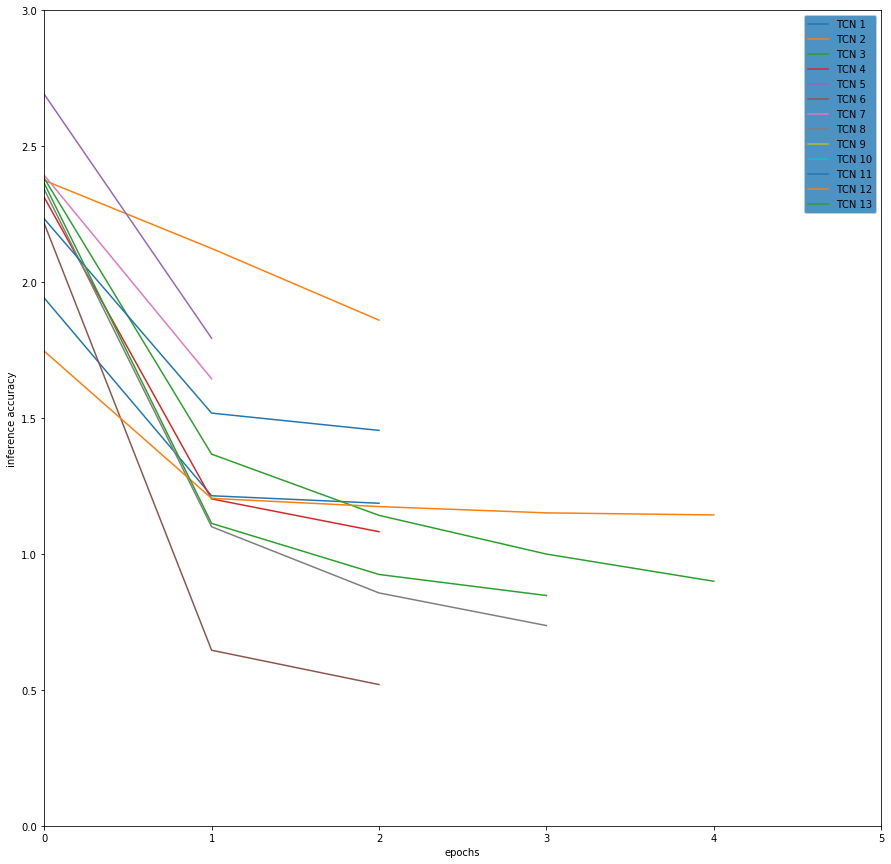

In [92]:
plotTrainLosses(scores=[s for s in scores if s['accuracies'][-1] >= 0.30], fsize=15, 
                xlabel='epochs', ylabel='inference accuracy', axis=[0, 5, 0, 3],
                    title='', p=first_parameters)

In [276]:
def bestModel(scores, list_parameters):
    best_accuracy = -1
    p = None
    s = None
    size = 0
    ii = None
    for i, score in enumerate(scores):
        if best_accuracy < score['accuracies'][-1]:
            s = score
            p = list_parameters[i]
            size = count_parameters(None, list_parameters[i])
            best_accuracy = max(score['accuracies'])
            ii = i
    print("Model {}".format(ii + 1))
    print("Best parameter => {}".format(p))
    print("Best accuracy => {}".format(max(s['accuracies'])))
    print("Size of model => {}".format(size))
    return s, p, size

### Best model from first search

In [275]:
best_score, best_parameters, msize = bestModel(scores, first_parameters)

Model 1
Best parameter => {'batch_size': 32, 'dropout': 0.34326058921300817, 'clip': 0.6493645456943744, 'lr': 0.005133514861863708, 'ksize': 5, 'levels': 4, 'optim': 'Adam', 'nhid': 19, 'epochs': 3, 'id': 1}
Best accuracy => 0.853
Size of model => 13272


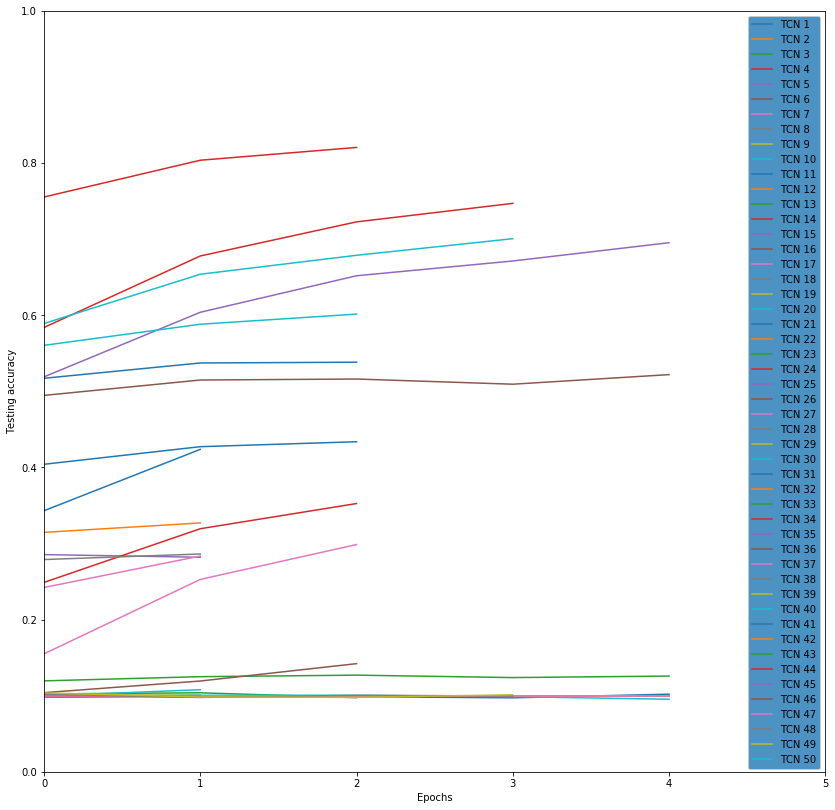

In [95]:
plotAccuracies(scores, fsize=14, acc_score=0.0, xlabel='Epochs', 
               ylabel='Testing accuracy', axis=[0, 5, 0, 1],
                title='')

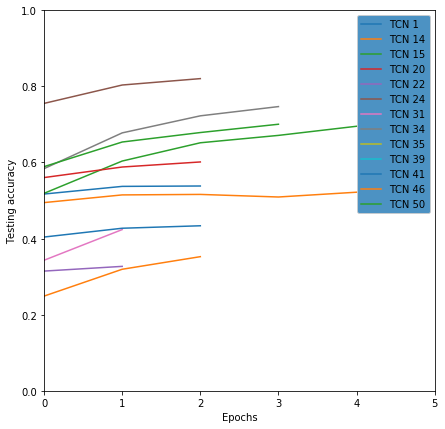

In [96]:
plotAccuracies(scores, fsize=7, acc_score=0.30, xlabel='Epochs', 
               ylabel='Testing accuracy', axis=[0, 5, 0, 1],
                title='')

### Train "best" TCNs for 15 epochs

In [97]:
def newParams(list_params, scores, acc_score):
    new_params = []
    for i, score in enumerate(scores):
        if max(score['accuracies']) > acc_score:
            list_params[i]['id'] = i + 1
            new_params.append(list_params[i])
    return new_params

In [98]:
first_best_params = newParams(first_parameters, scores, .30)
print(len(first_best_params))
first_best_params

13


[{'batch_size': 32,
  'dropout': 0.34326058921300817,
  'clip': 0.6493645456943744,
  'lr': 0.005133514861863708,
  'ksize': 5,
  'levels': 4,
  'optim': 'Adam',
  'nhid': 19,
  'epochs': 3,
  'id': 1},
 {'batch_size': 16,
  'dropout': 0.39809067121347863,
  'clip': 0.9813267052018477,
  'lr': 2.4284674647017572e-05,
  'ksize': 3,
  'levels': 6,
  'optim': 'Adam',
  'nhid': 26,
  'epochs': 3,
  'id': 14},
 {'batch_size': 16,
  'dropout': 0.018693763852867917,
  'clip': 0.631498049798557,
  'lr': 1.2222713916657822e-05,
  'ksize': 6,
  'levels': 6,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 5,
  'id': 15},
 {'batch_size': 16,
  'dropout': 0.49562306678041634,
  'clip': 0.7639972696295432,
  'lr': 0.012901279230041158,
  'ksize': 4,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 3,
  'id': 20},
 {'batch_size': 16,
  'dropout': 0.24270492434601254,
  'clip': 0.6105485393711059,
  'lr': 0.055380840366899005,
  'ksize': 4,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 17,
  'ep

In [99]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_channels = 1 # just one for the image
# classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# n_classes = len(classes) # 10 classes for fashion-mnist
# log_interval = 100
# seed = 1111
# torch.manual_seed(seed)
# permutee = False
# input_channels = 1
# seq_length = int(784 / input_channels)
# steps = 0
# cuda = True
# scores = []
# epochs = 15

# for model_indx, parameters in enumerate(o = load_obj('./best_models/scores')
# # list_params = load_obj('list_parameters')
# for i, score in enumerate(o):
#     print("Model {0}".format(i))
#     print("Parameters => {0}".format(new_params[i]))
#     print("Inference accuracy => {0}".format(score['accuracies'][-1]))
#     print("Train losses => {0}".format([losses[0][0] for losses in score['train_losses']]))
#     print("Test losses => {0}".format([losses for losses in score['test_losses']]))    ):
#     print(parameters)    
# #     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
# #     permute = permute.to(device)

#     train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

#     model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
#     model = nn.DataParallel(model)
#     model.to(device)
#     steps = 0
# #     print(count_parameters(model))
#     lr = parameters['lr']
#     optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
#     accuracies_ = []
#     train_losses_ = [[] for i in range(0, epochs)]
#     test_losses_ = []
#     file_name = './best_models/model_{0}.pt'.format(model_indx)

#     for epoch in range(1, epochs+1):
#         trainTCN(epoch)
#         test_losses_.append(testTCN())
#         if epoch % 5 == 0: 
#             print('Saving checkpoint for model.....')
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.module.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses_,
#                 'test_losses': test_losses_,
#                 'accuracies': accuracies_,
#                 'curr_lr': lr,
#             }, file_name)
#         if epoch % 10 == 0:
#             lr /= 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#     torch.save(model.module.state_dict(), file_name)
#     scores.append({
#         'accuracies': accuracies_,
#         'train_losses': train_losses_,
#         'test_losses': test_losses_,
#     })
#     print('Saved as %s' % file_name) 
# save_obj(scores, './best_models/scores')

In [100]:
new_scores = load_obj('./best_models/scores')
# fix old train_losses format
for i, score in enumerate(new_scores):
    score['train_losses'] = [s[0][0] for s in score['train_losses']]
show_models_results(new_scores, first_best_params)
# new_scores

Model 1
Parameters => {'batch_size': 32, 'dropout': 0.34326058921300817, 'clip': 0.6493645456943744, 'lr': 0.005133514861863708, 'ksize': 5, 'levels': 4, 'optim': 'Adam', 'nhid': 19, 'epochs': 3, 'id': 1}
Model size => 13272
Inference accuracy => 0.5859
Model 14
Parameters => {'batch_size': 16, 'dropout': 0.39809067121347863, 'clip': 0.9813267052018477, 'lr': 2.4284674647017572e-05, 'ksize': 3, 'levels': 6, 'optim': 'Adam', 'nhid': 26, 'epochs': 3, 'id': 14}
Model size => 23332
Inference accuracy => 0.4944
Model 15
Parameters => {'batch_size': 16, 'dropout': 0.018693763852867917, 'clip': 0.631498049798557, 'lr': 1.2222713916657822e-05, 'ksize': 6, 'levels': 6, 'optim': 'Adam', 'nhid': 28, 'epochs': 5, 'id': 15}
Model size => 52930
Inference accuracy => 0.7598
Model 20
Parameters => {'batch_size': 16, 'dropout': 0.49562306678041634, 'clip': 0.7639972696295432, 'lr': 0.012901279230041158, 'ksize': 4, 'levels': 7, 'optim': 'Adam', 'nhid': 28, 'epochs': 3, 'id': 20}
Model size => 42010
Inf

### Training Loss

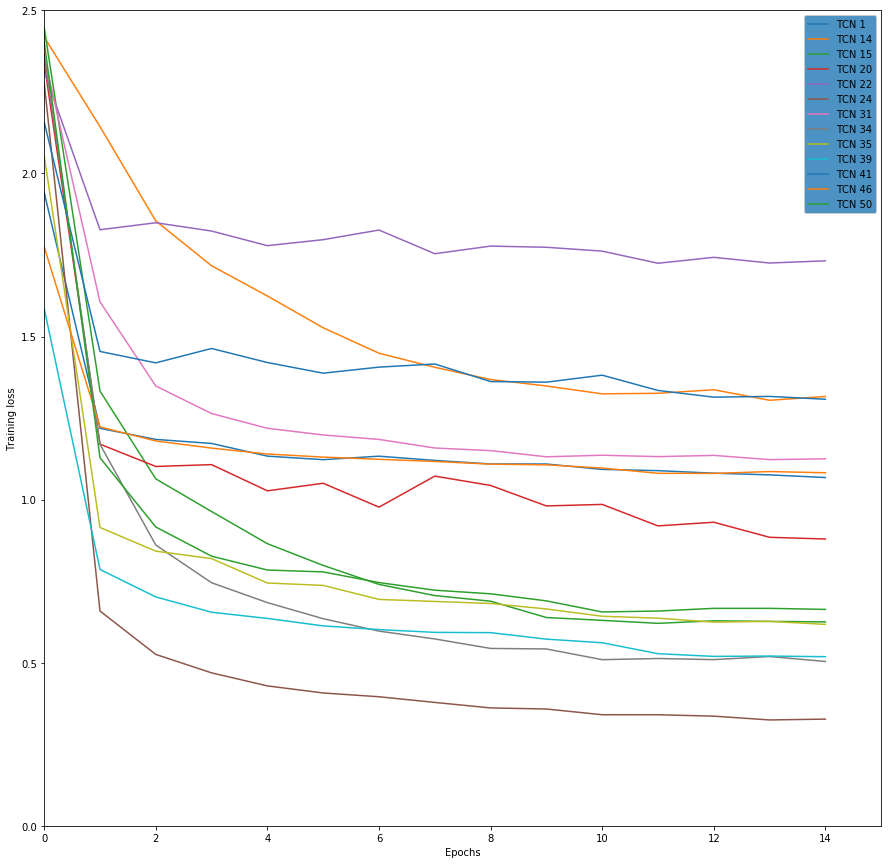

In [101]:
plotTrainLosses(scores=new_scores, fsize=15, 
                xlabel='Epochs', ylabel='Training loss', axis=[0, 15, 0, 2.5],
                    title='', p=first_best_params)



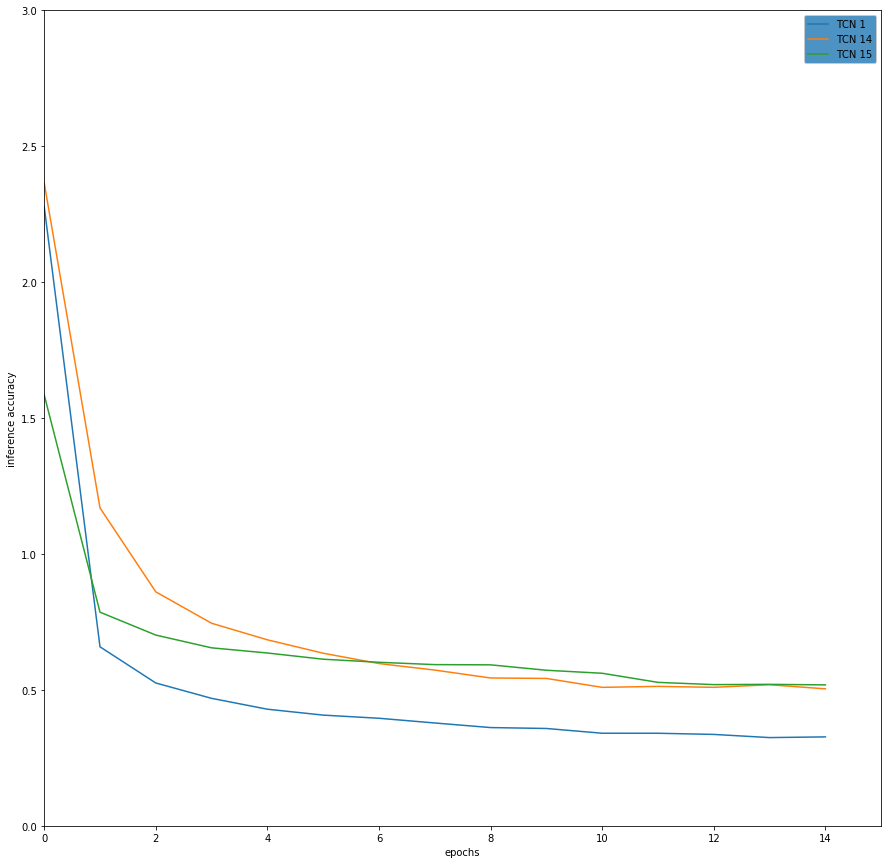

In [102]:
# print(new_scores)
plotTrainLosses(scores=[s for s in new_scores if s['accuracies'][-1] > .80], fsize=15, 
                xlabel='epochs', ylabel='inference accuracy', axis=[0, 15, 0, 3],
                    title='', p=first_best_params)
# print(first_best_params)
# print(new_scores)
    

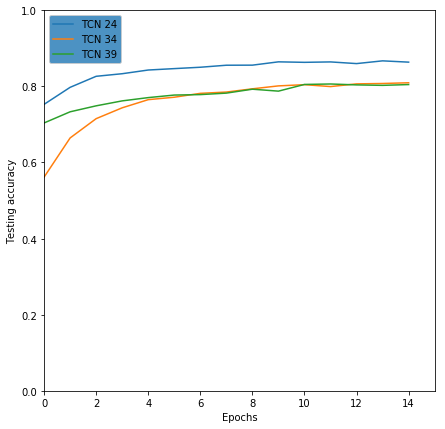

In [103]:
plotAccuracies(new_scores, fsize=7, acc_score=0.80, xlabel='Epochs', 
               ylabel='Testing accuracy', axis=[0, 15, 0, 1],
                title='', 
               p=first_best_params)

In [104]:


# import random
# num_models = 50
# seen_hyper = set()
# list_parameters = [{} for i in range(0, num_models)]
# for i in range(0, num_models):
#     while(True):
#         list_parameters[i]['batch_size'] = random.choice([32, 64, 128])
#         list_parameters[i]['dropout'] = np.random.uniform(0., 0.60)
#         list_parameters[i]['clip'] = np.random.uniform(0.2, 1)
#         list_parameters[i]['lr'] = pow(10, np.random.uniform(-6, -2))
#         list_parameters[i]['ksize'] = np.random.randint(3, 7)
#         list_parameters[i]['levels'] = np.random.randint(5, 9)
#         list_parameters[i]['optim'] = 'Adam'
#         list_parameters[i]['nhid'] = np.random.randint(20, 30)
#         list_parameters[i]['epochs'] = 5
#         k = "".join(str(v) + '_' for k, v in list_parameters[i].items())
#         if k not in seen_hyper:
#             seen_hyper.add(k)
#             break
# save_obj(list_parameters, 'new_list_parameters')
# [param for param in list_parameters]

In [105]:
# # def runListParams(list_parameters):
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_channels = 1 # just one for the image
# classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# n_classes = len(classes) # 10 classes for fashion-mnist
# log_interval = 100
# seed = 1111
# torch.manual_seed(seed)
# permutee = False
# input_channels = 1
# seq_length = int(784 / input_channels)
# steps = 0
# cuda = True
# scores = []

# for model_indx, parameters in enumerate(list_parameters):
#     print(parameters)    
# #     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
# #     permute = permute.to(device)

#     train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

#     model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
#     model = nn.DataParallel(model)
#     model.to(device)
#     steps = 0
# #     print(count_parameters(model))
#     lr = parameters['lr']
#     optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
#     accuracies_ = []
#     train_losses_ = [[] for i in range(0, parameters['epochs'])]
#     test_losses_ = []
#     file_name = './best_models/model_{0}_scnd_tunning.pt'.format(model_indx)

#     for epoch in range(1, parameters['epochs']+1):
#         trainTCN(epoch)
#         test_losses_.append(testTCN())
#         if epoch % 5 == 0: 
#             print('Saving checkpoint for model.....')
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.module.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses_,
#                 'test_losses': test_losses_,
#                 'accuracies': accuracies_,
#                 'curr_lr': lr,
#             }, file_name)
#         if epoch % 10 == 0:
#             lr /= 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#     torch.save(model.module.state_dict(), file_name)
#     scores.append({
#         'accuracies': accuracies_,
#         'train_losses': train_losses_,
#         'test_losses': test_losses_,
#     })
#     print('Saved as %s' % file_name) 
# save_obj(scores, './best_models/scores_1')

In [106]:
scores = load_obj('./best_models/scores_1')
list_params = load_obj('new_list_parameters')
for i,p in enumerate(list_params):
    p['id'] = i + 1
for i, score in enumerate(scores):
    score['train_losses'] = [s[0][0] for s in score['train_losses']]
# for i, score in enumerate(scores):
#     if score['accuracies'][-1] > .70:
# #         print(list_params[i])
#         print("Model {0}".format(i + 1))
#         print("Parameters => {0}".format(list_params[i]))
#         print("Inference accuracy => {0}".format(score['accuracies'][-1]))
#         print("Train losses => {0}".format([losses[0][0] for losses in score['train_losses']]))
#         print("Test losses => {0}".format([losses for losses in score['test_losses']]))    

list_params

[{'batch_size': 32,
  'dropout': 0.5867010918637766,
  'clip': 0.8424842254032971,
  'lr': 0.0005321413416390871,
  'ksize': 3,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 22,
  'epochs': 5,
  'id': 1},
 {'batch_size': 128,
  'dropout': 0.5954237096961861,
  'clip': 0.31934631242852457,
  'lr': 0.00010627592593707352,
  'ksize': 6,
  'levels': 6,
  'optim': 'Adam',
  'nhid': 20,
  'epochs': 5,
  'id': 2},
 {'batch_size': 128,
  'dropout': 0.3374395737641672,
  'clip': 0.6471912413872007,
  'lr': 0.0012033676497161245,
  'ksize': 6,
  'levels': 5,
  'optim': 'Adam',
  'nhid': 24,
  'epochs': 5,
  'id': 3},
 {'batch_size': 32,
  'dropout': 0.054427468927671474,
  'clip': 0.8291600263170378,
  'lr': 0.0001914417943740598,
  'ksize': 5,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 24,
  'epochs': 5,
  'id': 4},
 {'batch_size': 32,
  'dropout': 0.2732913948200143,
  'clip': 0.37714226041960547,
  'lr': 1.6604535938909617e-05,
  'ksize': 3,
  'levels': 6,
  'optim': 'Adam',
  'nhid': 29,
  'e

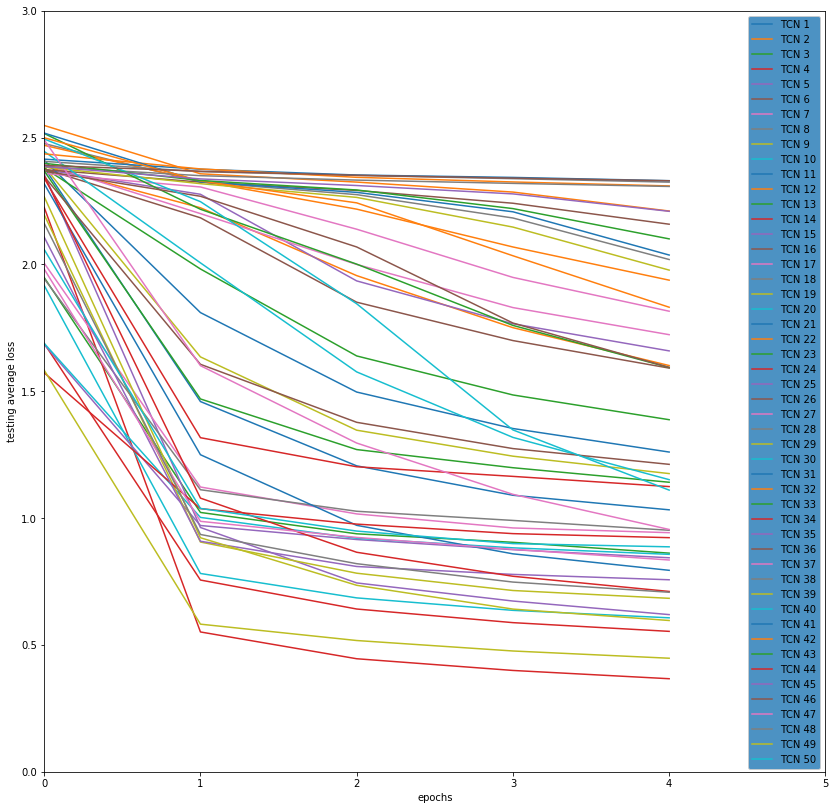

In [107]:
plotTrainLosses(scores, fsize=14, xlabel='epochs', ylabel='testing average loss', 
                title='', p=list_params)


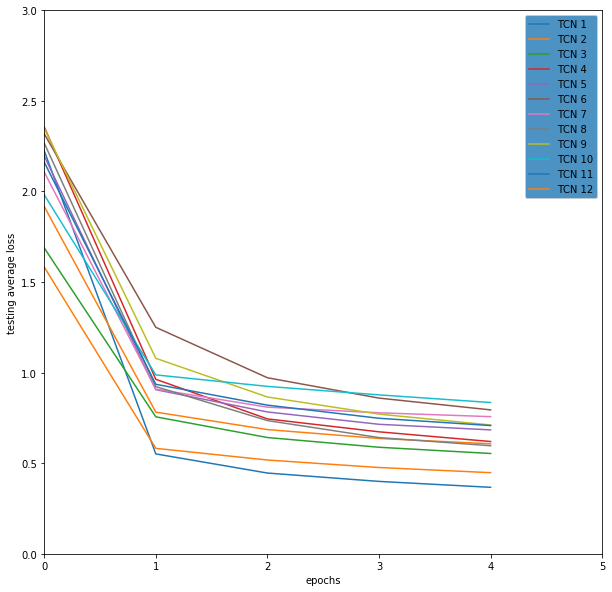

In [108]:
plotTrainLosses([s for s in scores if s['accuracies'][-1] >= 0.70], fsize=10, xlabel='epochs', 
                ylabel='testing average loss', 
                title='',
               axis=[0, 5, 0, 3], p=list_params)


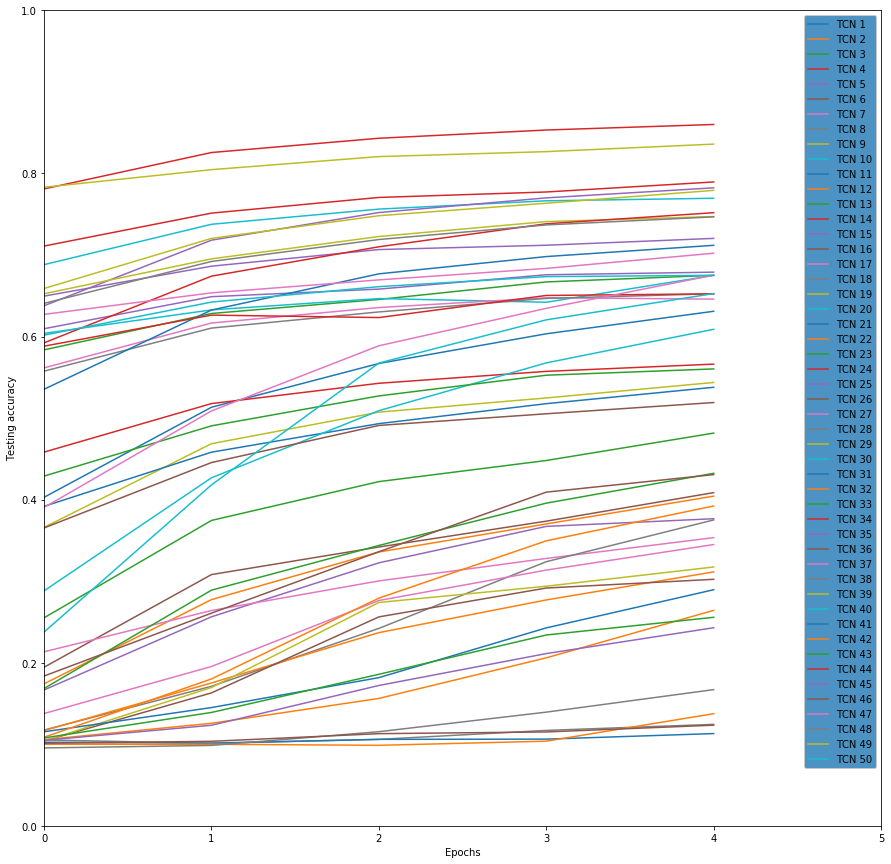

In [109]:
plotAccuracies(scores, fsize=15, acc_score=0., xlabel='Epochs', 
               ylabel='Testing accuracy', axis=[0, 5, 0, 1],
                title='', p=list_params)

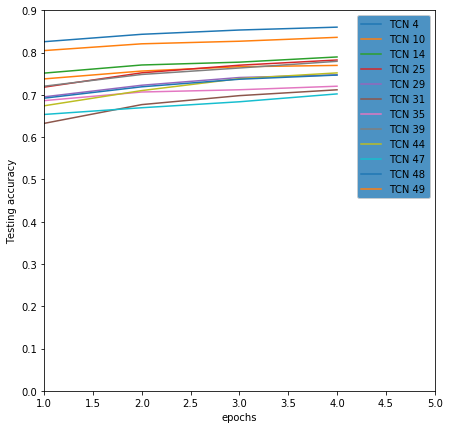

In [110]:
plotAccuracies(scores, fsize=7, acc_score=0.7, xlabel='epochs', 
               ylabel='Testing accuracy', axis=[1, 5, 0, 0.9],
                title='')

In [158]:
# best_score = -1
# best_i = -1
# for i, score in enumerate(scores):
#     if score['accuracies'][-1] > best_score:
#         best_score = score['accuracies'][-1]
#         best_i = i
# print(best_score)
# best_i
# list_params[best_i]
best_score, best_parameters, msize = bestModel(scores, list_params)

Model 1
Best parameter => {'batch_size': 32, 'dropout': 0.5867010918637766, 'clip': 0.8424842254032971, 'lr': 0.0005321413416390871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 22, 'epochs': 5, 'id': 1}
Best accuracy => 0.8777
Size of model => 22824


In [115]:
new_list_params = []
for i, score in enumerate(scores):
    if score['accuracies'][-1] > .70:
        new_list_params.append((list_params[i], i))
new_list_params

[({'batch_size': 32,
   'dropout': 0.5867010918637766,
   'clip': 0.8424842254032971,
   'lr': 0.0005321413416390871,
   'ksize': 3,
   'levels': 8,
   'optim': 'Adam',
   'nhid': 22,
   'epochs': 5,
   'id': 1},
  0),
 ({'batch_size': 128,
   'dropout': 0.5954237096961861,
   'clip': 0.31934631242852457,
   'lr': 0.00010627592593707352,
   'ksize': 6,
   'levels': 6,
   'optim': 'Adam',
   'nhid': 20,
   'epochs': 5,
   'id': 2},
  1),
 ({'batch_size': 128,
   'dropout': 0.3374395737641672,
   'clip': 0.6471912413872007,
   'lr': 0.0012033676497161245,
   'ksize': 6,
   'levels': 5,
   'optim': 'Adam',
   'nhid': 24,
   'epochs': 5,
   'id': 3},
  2),
 ({'batch_size': 32,
   'dropout': 0.054427468927671474,
   'clip': 0.8291600263170378,
   'lr': 0.0001914417943740598,
   'ksize': 5,
   'levels': 8,
   'optim': 'Adam',
   'nhid': 24,
   'epochs': 5,
   'id': 4},
  3),
 ({'batch_size': 32,
   'dropout': 0.2732913948200143,
   'clip': 0.37714226041960547,
   'lr': 1.6604535938909617e-05

### Test again

In [113]:
# # def runListParams(list_parameters):
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_channels = 1 # just one for the image
# classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# n_classes = len(classes) # 10 classes for fashion-mnist
# log_interval = 100
# seed = 1111
# torch.manual_seed(seed)
# permutee = False
# input_channels = 1
# seq_length = int(784 / input_channels)
# steps = 0
# cuda = True
# scores = []
# epochs = 15

# for model_indx, parameters in enumerate(new_list_params):
#     print(parameters)
# #     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
# #     permute = permute.to(device)

#     train_loader, test_loader = data_generator('../data/fashion_mnist', parameters[0]['batch_size'])

#     model = TCN(input_channels, n_classes, hidden_units=parameters[0]['nhid'], levels=parameters[0]['levels'], kernel_size=parameters[0]['ksize'], dropout=parameters[0]['dropout'])
#     model = nn.DataParallel(model)
#     model.to(device)
#     steps = 0
#     print("size of model => {0}".format(count_parameters(model)))
#     lr = parameters[0]['lr']
#     optimizer = getattr(optim, parameters[0]['optim'])(model.parameters(), lr=lr)
#     accuracies_ = []
#     train_losses_ = [[] for i in range(0, epochs)]
#     test_losses_ = []
#     file_name = './best_models/thrd_tunning_model_{0}.pt'.format(model_indx)

#     for epoch in range(1, epochs+1):
#         trainTCN(epoch)
#         test_losses_.append(testTCN())
#         if epoch % 5 == 0: 
#             print('Saving checkpoint for model.....')
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.module.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses_,
#                 'test_losses': test_losses_,
#                 'accuracies': accuracies_,
#                 'curr_lr': lr,
#             }, file_name)
#         if epoch % 10 == 0:
#             lr /= 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#     torch.save(model.module.state_dict(), file_name)
#     scores.append({
#         'accuracies': accuracies_,
#         'train_losses': train_losses_,
#         'test_losses': test_losses_,
#     })
#     print('Saved as %s' % file_name) 
# save_obj(scores, './best_models/scores_2_thrd_tunning')

({'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': 0.8291600263170378, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5, 'id': 4}, 3)
size of model => 44386


TypeError: tuple indices must be integers or slices, not str

In [137]:
scores = load_obj('./best_models/scores_2_thrd_tunning')
# for i, score in enumerate(scores):
# #     print(new_list_params[i])
#     print(score['accuracies'][-1])

# new_list_params = [p[0] for p in new_list_params]
# new_list_params
for s in scores:
    s['train_losses'] = [ss[0][0] for ss in s['train_losses']]
print(scores[0])

{'accuracies': [0.7817, 0.8229, 0.8331, 0.8459, 0.8532, 0.8563, 0.8634, 0.8651, 0.8679, 0.8707, 0.8755, 0.8774, 0.8774, 0.8777, 0.8759], 'train_losses': [2.2820826530456544, 0.5601750496029854, 0.44303445115685464, 0.4256318320333958, 0.38676123864948747, 0.36814457073807716, 0.350119332075119, 0.3268333727866411, 0.32955382473766803, 0.31385687328875067, 0.30394390277564526, 0.2947215918451548, 0.2821521120518446, 0.29608928866684436, 0.286869455948472], 'test_losses': [0.6111885613918304, 0.5014329420089721, 0.4659966171979904, 0.4231648623466492, 0.4014820334672928, 0.38842447152137755, 0.37917939920425414, 0.37844721367359163, 0.36277054500579836, 0.3600977731943131, 0.3420574465274811, 0.3356927355527878, 0.3358356834053993, 0.3355303660392761, 0.337239381980896]}


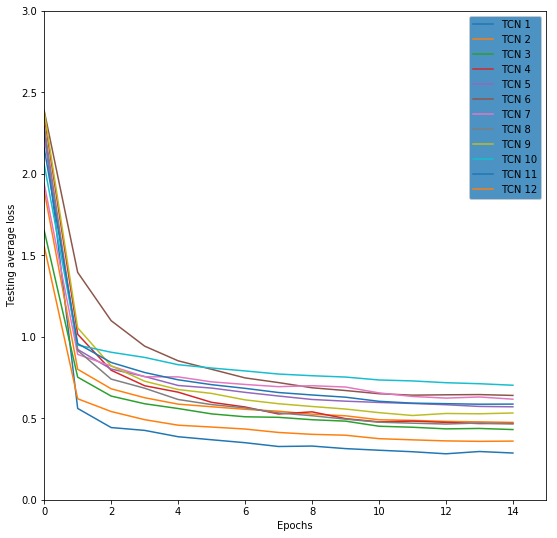

In [146]:
plotTrainLosses(scores, fsize=9, xlabel='Epochs', ylabel='Testing average loss',
                axis=[0, 15, 0, 3],
                title='', p=new_list_params)

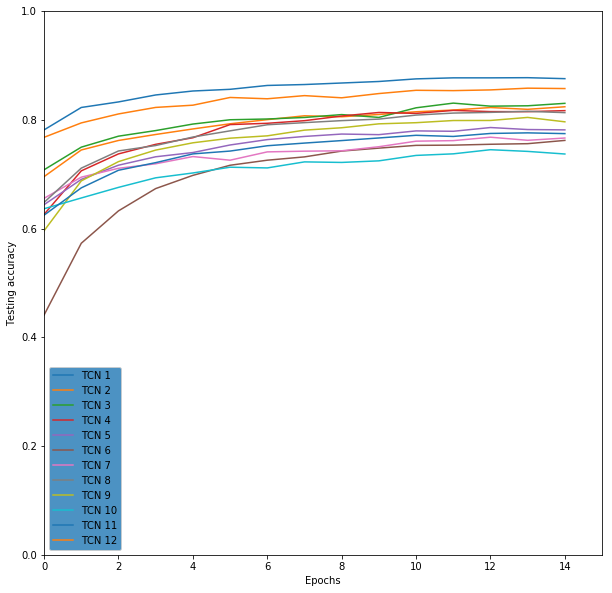

In [147]:
plotAccuracies(scores, fsize=10, acc_score=0.0, xlabel='Epochs', 
               ylabel='Testing accuracy', axis=[0, 15, 0, 1],
                title='', p=new_list_params)

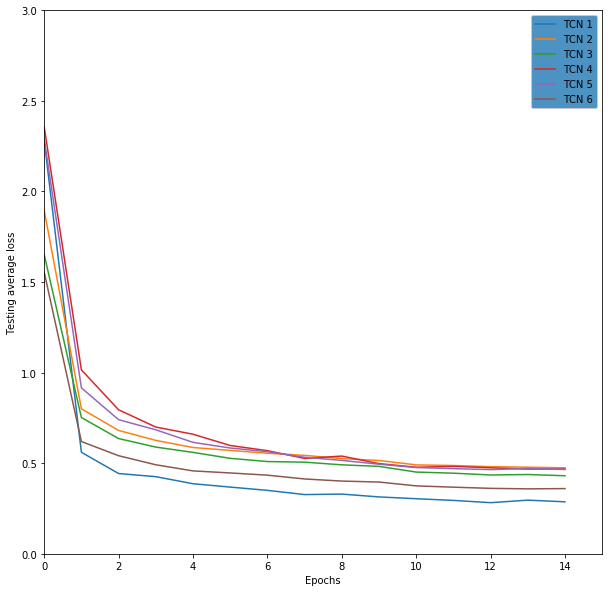

In [155]:
plotTrainLosses([score for score in scores if score['accuracies'][-1] > .80], fsize=10, 
                xlabel='Epochs', ylabel='Testing average loss', axis=[0, 15, 0, 3],
                title='', p=new_list_params)

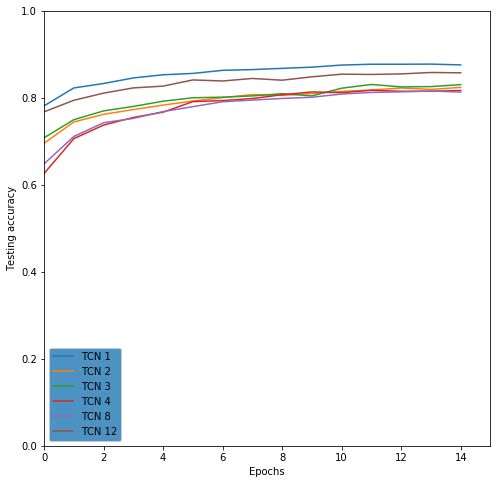

In [156]:
plotAccuracies(scores, fsize=8, acc_score=0.8, xlabel='Epochs', 
               ylabel='Testing accuracy', axis=[0, 15, 0, 1],
                title='', p=new_list_params)

In [157]:
best_score, best_parameters, msize = bestModel(scores, new_list_params)

Model 1
Best parameter => {'batch_size': 32, 'dropout': 0.5867010918637766, 'clip': 0.8424842254032971, 'lr': 0.0005321413416390871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 22, 'epochs': 5, 'id': 1}
Best accuracy => 0.8777
Size of model => 22824


In [463]:
# # def runListParams(list_parameters):
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_channels = 1 # just one for the image
# classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# n_classes = len(classes) # 10 classes for fashion-mnist
# log_interval = 100
# seed = 1111
# torch.manual_seed(seed)
# permutee = False
# input_channels = 1
# seq_length = int(784 / input_channels)
# steps = 0
# cuda = True
# scores = []
# epochs = 5

# for model_indx, parameters in enumerate(fake_list_params):
#     print(parameters)
# #     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
# #     permute = permute.to(device)

#     train_loader, test_loader = data_generator('../data/fashion_mnist', parameters[0]['batch_size'])

#     model = TCN(input_channels, n_classes, hidden_units=parameters[0]['nhid'], levels=parameters[0]['levels'], kernel_size=parameters[0]['ksize'], dropout=parameters[0]['dropout'])
#     model = nn.DataParallel(model)
#     model.to(device)
#     steps = 0
#     print("size of model => {0}".format(count_parameters(model)))
#     lr = parameters[0]['lr']
#     optimizer = getattr(optim, parameters[0]['optim'])(model.parameters(), lr=lr)
#     accuracies_ = []
#     train_losses_ = [[] for i in range(0, epochs)]
#     test_losses_ = []
#     file_name = './best_models/debug_tunning_model_{0}.pt'.format(model_indx)

#     for epoch in range(1, epochs+1):
#         trainTCN(epoch)
#         test_losses_.append(testTCN())
#         if epoch % 5 == 0: 
#             print('Saving checkpoint for model.....')
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.module.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses_,
#                 'test_losses': test_losses_,
#                 'accuracies': accuracies_,
#                 'curr_lr': lr,
#             }, file_name)
#         if epoch % 10 == 0:
#             lr /= 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#     torch.save(model.module.state_dict(), file_name)
#     scores.append({
#         'accuracies': accuracies_,
#         'train_losses': train_losses_,
#         'test_losses': test_losses_,
#     })
#     print('Saved as %s' % file_name) 
# save_obj(scores, './best_models/debug')

({'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': -1, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5}, 3)
size of model => 44386
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.282939	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.712290	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.193242	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.991922	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.900778	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.849686	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.787597	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.749365	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.724834	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.688478	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.665505	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.650412	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.637055

Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.700500	Steps: 79184
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.086888	Steps: 157584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.922996	Steps: 235984
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.827692	Steps: 314384

Test set: Average loss: 0.7820, Accuracy: 7108/10000 (71%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.747131	Steps: 446880
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.722494	Steps: 525280
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.698472	Steps: 603680
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.669666	Steps: 682080

Test set: Average loss: 0.6992, Accuracy: 7389/10000 (73%)

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.651949	Steps: 814576
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.646463	Steps: 892976
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.634304	Steps: 971376
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.618507	Steps: 1049776

Test set: Average loss: 0.6370, Accuracy: 7589/10000 (75%)

Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.601183

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.234217	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.665588	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.365123	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.193374	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.096761	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.015308	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.992800	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.941188	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.908602	Steps: 706384

Test set: Average loss: 0.9229, Accuracy: 6509/10000 (65%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.908059	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.882795	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.867203	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.851318	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.824288	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.8

Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.733899	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.720546	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.735110	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.717697	Steps: 3647952

Test set: Average loss: 0.7287, Accuracy: 7310/10000 (73%)

Saving checkpoint for model.....
Saved as ./best_models/debug_tunning_model_6.pt
({'batch_size': 64, 'dropout': 0.12912180440316612, 'clip': -1, 'lr': 0.00024394817806865665, 'ksize': 4, 'levels': 7, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}, 38)
size of model => 23866
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300854	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.804503	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.365986	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.184893	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.079512	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.989611	Steps: 471184
Train Epoch: 1 [44800/60000

Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.702710	Steps: 5116384
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.688441	Steps: 5194784
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.680527	Steps: 5273184
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.665024	Steps: 5351584
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.664162	Steps: 5429984
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.681965	Steps: 5508384
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.687540	Steps: 5586784
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.644727	Steps: 5665184
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.686607	Steps: 5743584
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.667285	Steps: 5821984

Test set: Average loss: 0.6715, Accuracy: 7474/10000 (74%)

Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.660290	Steps: 5959184
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.642318	Steps: 6037584
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.663599	Steps: 6115984
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.641389	Steps: 6194384
Train Epoch: 5 [16000/60000 (27%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.761331	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.757931	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.754837	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.756476	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.765203	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.736210	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.726805	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.737337	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.736959	Steps: 2912560

Test set: Average loss: 0.7376, Accuracy: 7250/10000 (72%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.722698	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.721347	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.732624	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.717712	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.730973	Steps: 3334352
Train Epoch: 5 [38400/60000 (64

In [160]:
scores = load_obj('./best_models/debug')
fake_list_params = new_list_params

for i, score in enumerate(scores):
    print(score['accuracies'][-1])
    print(fake_list_params[i])

0.853
{'batch_size': 32, 'dropout': 0.5867010918637766, 'clip': 0.8424842254032971, 'lr': 0.0005321413416390871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 22, 'epochs': 5, 'id': 1}
0.7672
{'batch_size': 128, 'dropout': 0.5954237096961861, 'clip': 0.31934631242852457, 'lr': 0.00010627592593707352, 'ksize': 6, 'levels': 6, 'optim': 'Adam', 'nhid': 20, 'epochs': 5, 'id': 2}
0.7837
{'batch_size': 128, 'dropout': 0.3374395737641672, 'clip': 0.6471912413872007, 'lr': 0.0012033676497161245, 'ksize': 6, 'levels': 5, 'optim': 'Adam', 'nhid': 24, 'epochs': 5, 'id': 3}
0.7784
{'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': 0.8291600263170378, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5, 'id': 4}
0.7431
{'batch_size': 32, 'dropout': 0.2732913948200143, 'clip': 0.37714226041960547, 'lr': 1.6604535938909617e-05, 'ksize': 3, 'levels': 6, 'optim': 'Adam', 'nhid': 29, 'epochs': 5, 'id': 5}
0.7233
{'batch_size': 32, 'dropout': 0.5093

In [225]:
scores_1 = load_obj('./best_models/manual_scores_1')
scores_1[0]['accuracies'][-1]
scores_1 = scores_1[0]

scores_1['train_losses'] = [l[0] for l in scores_1['train_losses']]
print(scores_1)

{'accuracies': [0.8469, 0.8588, 0.8668, 0.8661, 0.867, 0.8743, 0.8742, 0.8719, 0.8802, 0.8829], 'train_losses': [1.2953958266973495, 0.39714042976498604, 0.34741347536444667, 0.3212203884124756, 0.3028074014186859, 0.2903767862915993, 0.27683846309781074, 0.26200838789343833, 0.25394085705280306, 0.24482859864830972]}


In [226]:
scores_2 = load_obj('./best_models/manual_scores_0')
scores_2[0]['accuracies'][-1]
# [l for l in scores_2['train_losses']]
# scores_2
scores_2 = scores_2[0]
# socres_1['trai']
scores_2['train_losses']= [l[0] for l in scores_2['train_losses']]

In [230]:
paper_scores= [scores_1, scores_2]
# paper_scores[0]['train_losses'] = paper_scores[0]['training_loses']

# for i, p in enumerate(paper_scores):
#     print(p['accuracies'][-1])

# paper_scores[1]['train_losses']
# paper_scores[1]['train_losses'] = paper_scores[1].pop('train_loses')
# paper_scores[0]['train_losses'] = paper_scores[0].pop('training_loses')
# for i, score in enumerate(paper_scores):
#     print(score)
# #     if score['accuracies'][-1] >= acc_score:
# #         ax.plot([s for s in score['accuracies']], label="TCN {0}".format(i))

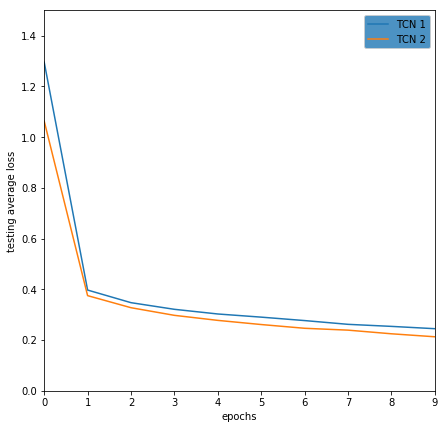

In [238]:
# [score for score in paper_scores if score['accuracies'][-1] > .80]
plotTrainLosses([score for score in paper_scores if score['accuracies'][-1] > .80], fsize=7, 
                xlabel='epochs', ylabel='testing average loss', axis=[0, 9, 0, 1.50],
                title='')

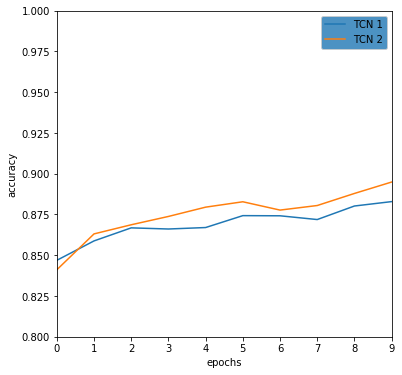

In [245]:
plotAccuracies(paper_scores, fsize=6, acc_score=0.25, xlabel='epochs', 
               ylabel='accuracy', axis=[0, 9, 0.8, 1],
                title='')

In [179]:
# paper_params = set_parameters(50, [64], dropout=[0.0, 0.0], clip=[-1, -1], lr=[-4, -2], 
#                              ksize=[5, 13], levels=[6, 11], optim='Adam', nhid=[20, 31],
#                              epochs=[5,6])

# save_obj(paper_params, 'paper_parameters')
# paper_params

[{'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0018660497750821964,
  'ksize': 10,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 27,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0015298719814126683,
  'ksize': 6,
  'levels': 10,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.00624651963066543,
  'ksize': 11,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 29,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.00027339239229661686,
  'ksize': 12,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 21,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0009337282316908241,
  'ksize': 6,
  'levels': 9,
  'optim': 'Adam',
  'nhid': 20,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.00012179821087315272,
  'ksize': 12,
  'levels': 10,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 5},
 {'batch_size': 

In [ ]:
# # def runListParams(list_parameters):
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_channels = 1 # just one for the image
# classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# n_classes = len(classes) # 10 classes for fashion-mnist
# log_interval = 100
# seed = 1111
# torch.manual_seed(seed)
# permutee = False
# input_channels = 1
# seq_length = int(784 / input_channels)
# steps = 0
# cuda = True
# scores = []
# # epochs = 15

# for model_indx, parameters in enumerate(paper_params):
#     print(parameters)
# #     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
# #     permute = permute.to(device)

#     train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

#     model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
#     model = nn.DataParallel(model)
#     model.to(device)
#     steps = 0
#     print("size of model => {0}".format(count_parameters(model)))
#     lr = parameters['lr']
#     optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
#     accuracies_ = []
#     train_losses_ = [0 for _ in range(len(clases))]
# #     print(train_losses_)
#     test_losses_ = []
#     file_name = './best_models/paper_tunning{0}.pt'.format(model_indx)

#     for epoch in range(1, parameters['epochs']+1):
#         trainTCN(epoch)
#         test_losses_.append(testTCN())
#         if epoch % 5 == 0: 
#             print('Saving checkpoint for model.....')
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.module.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses_,
#                 'test_losses': test_losses_,
#                 'accuracies': accuracies_,
#                 'curr_lr': lr,
#             }, file_name)
#         if epoch % 10 == 0:
#             lr /= 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#     torch.save(model.module.state_dict(), file_name)
#     scores.append({
#         'accuracies': accuracies_,
#         'train_losses': train_losses_,
#         'test_losses': test_losses_,
#     })
#     print('Saved as %s' % file_name) 
# save_obj(scores, './best_models/paper_tunning')

{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0018660497750821964, 'ksize': 10, 'levels': 8, 'optim': 'Adam', 'nhid': 27, 'epochs': 5}
size of model => 110818
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.087552	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.647717	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.540767	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.486724	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.450692	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.434605	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.414104	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.406314	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.391482	Steps: 706384

Test set: Average loss: 0.4236, Accuracy: 8416/10000 (84%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.375996	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.370064	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.374983	Steps: 971376
Trai

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.436301	Steps: 1441776

Test set: Average loss: 0.4752, Accuracy: 8338/10000 (83%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.427025	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.427478	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.443328	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.415666	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.410544	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.408970	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.393427	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.411572	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.405340	Steps: 2177168

Test set: Average loss: 0.4349, Accuracy: 8451/10000 (84%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.386359	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.394052	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.410249	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.319024	Steps: 2912560

Test set: Average loss: 0.3458, Accuracy: 8754/10000 (87%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.304370	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.290717	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.305749	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.288828	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.300562	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.293147	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.286304	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.290984	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.301639	Steps: 3647952

Test set: Average loss: 0.3345, Accuracy: 8800/10000 (88%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning4.pt
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00012179821087315272, 'ksize': 12, 'levels': 10, 'optim': 'Adam', 'nhid': 28, 'epochs': 5}
size of

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.557944	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.514703	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.500569	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.488106	Steps: 706384

Test set: Average loss: 0.5160, Accuracy: 8164/10000 (81%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.462616	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.452947	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.454526	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.441061	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.426757	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.422563	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.407706	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.407475	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.409593	Steps: 1441776

Test set: Average loss: 0.4256, Accuracy: 8452/10000 (84%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0

Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.419036	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.424023	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.425296	Steps: 2177168

Test set: Average loss: 0.4451, Accuracy: 8423/10000 (84%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.404671	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.409924	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.414587	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.395610	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.395834	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.396578	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.381845	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.392245	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.395407	Steps: 2912560

Test set: Average loss: 0.4109, Accuracy: 8551/10000 (85%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.369467	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.285994	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.284227	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.299137	Steps: 3647952

Test set: Average loss: 0.3470, Accuracy: 8701/10000 (87%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning11.pt
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.000540490539221378, 'ksize': 12, 'levels': 7, 'optim': 'Adam', 'nhid': 30, 'epochs': 5}
size of model => 141970
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.320867	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.719457	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.623688	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.548543	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.495350	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.484353	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.446280	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.445790	Step

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.536243	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.521400	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.511573	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.492528	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.491587	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.488011	Steps: 1441776

Test set: Average loss: 0.4878, Accuracy: 8224/10000 (82%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.457965	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.462429	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.471702	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.456693	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.451531	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.447566	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.430691	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.439573	Steps: 2098768
Train Epoch: 3 [57600/60000 (9

Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.328809	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.330730	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.331987	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.322636	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.329588	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.337110	Steps: 2912560

Test set: Average loss: 0.3478, Accuracy: 8742/10000 (87%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.313938	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.313123	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.324077	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.307406	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.312111	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.314562	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.304613	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.310709	Steps: 3569552
Train Epoch: 5 [57600/60000 (9

Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.265762	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.672070	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.592810	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.510374	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.488706	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.464169	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.428049	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.429718	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.412340	Steps: 706384

Test set: Average loss: 0.4465, Accuracy: 8378/10000 (83%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.387932	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.385201	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.391694	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.364866	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.364709	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.3

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.449383	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.454586	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.446055	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.439708	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.440528	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.419229	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.428758	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.430517	Steps: 2177168

Test set: Average loss: 0.4330, Accuracy: 8419/10000 (84%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.408303	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.404447	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.409949	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.402126	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.405475	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.402458	Steps: 2677360
Train Epoch: 4 [44800/60000 (7

Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.548433	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.569135	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.556464	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.550833	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.531784	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.533064	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.537570	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.544027	Steps: 3647952

Test set: Average loss: 0.5485, Accuracy: 7941/10000 (79%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning23.pt
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00011173884399839355, 'ksize': 6, 'levels': 10, 'optim': 'Adam', 'nhid': 30, 'epochs': 5}
size of model => 104350
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.228695	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.221106	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.8545

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.496596	Steps: 706384

Test set: Average loss: 0.4941, Accuracy: 8209/10000 (82%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.464784	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.465369	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.455574	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.436029	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.428839	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.418081	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.401640	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.406119	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.409576	Steps: 1441776

Test set: Average loss: 0.4216, Accuracy: 8483/10000 (84%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.392416	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.393134	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.395737	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.441306	Steps: 2177168


In [249]:
paper_scores = load_obj('./best_models/paper_tunning')
paper_params = load_obj('paper_parameters')
for score in paper_scores:
    score['train_losses'] = score['train_losses'][:5]
# (paper_scores[0]['train_losses'][:5])
for i, score in enumerate(paper_scores):
    for y, s in enumerate(score['train_losses']):
#         print(i, y, s/10000)
        paper_scores[i]['train_losses'][y] = s / 10000

# [p['train_losses'] for p in paper_scores]
paper_scores
for i, p in enumerate(paper_params):
    p['id'] = i + 1

In [265]:
# paper_parameters = load_obj('paper_parameters')
# len(paper_parameters)
# show_models_results(paper_scores, paper_params)
best_score, best_parameters, msize = bestModel(paper_scores, paper_params)

Model 26
Best parameter => {'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0006393446641262778, 'ksize': 10, 'levels': 10, 'optim': 'Adam', 'nhid': 26, 'epochs': 5, 'id': 26}
Best accuracy => 0.8848
Size of model => 130062


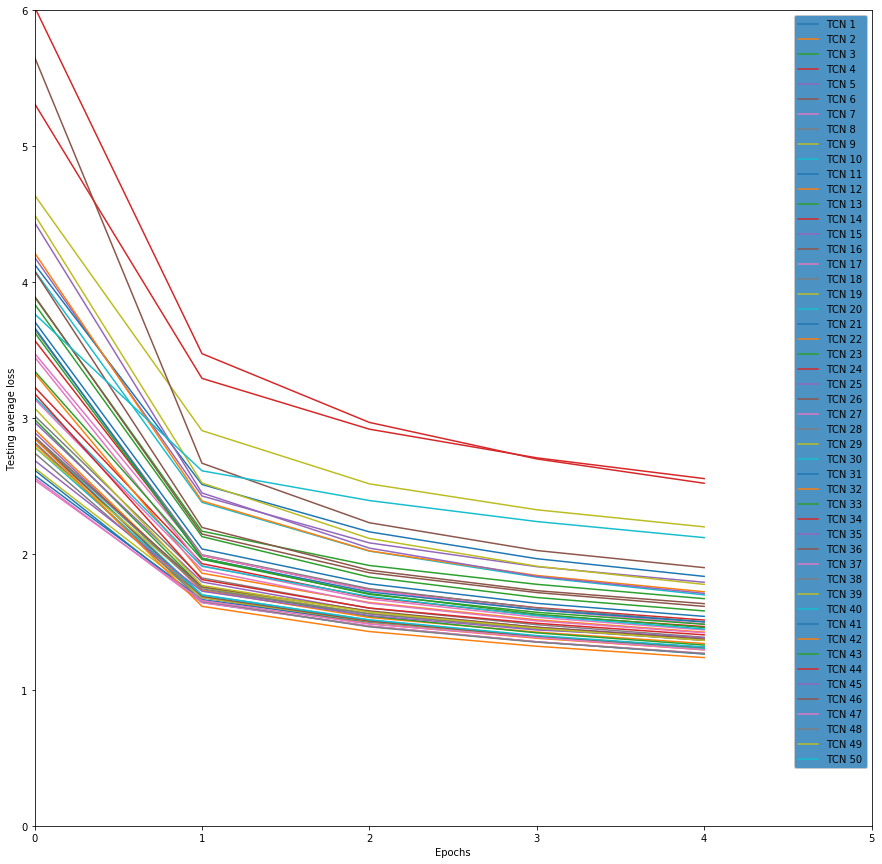

In [255]:
plotTrainLosses(paper_scores, fsize=15, 
                xlabel='Epochs', ylabel='Testing average loss', axis=[0, 5, 0, 6],
                title='', p=paper_params)

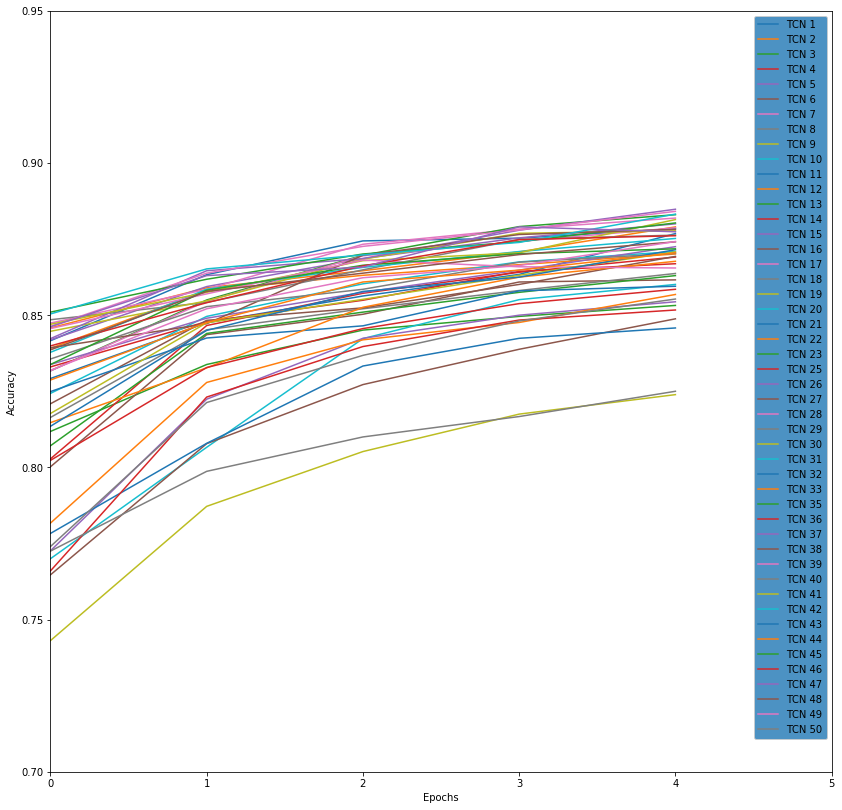

In [257]:
plotAccuracies(paper_scores, fsize=14, acc_score=0.80, xlabel='Epochs', 
               ylabel='Accuracy', axis=[0, 5, 0.70, 0.95],
                title='', p=paper_params)

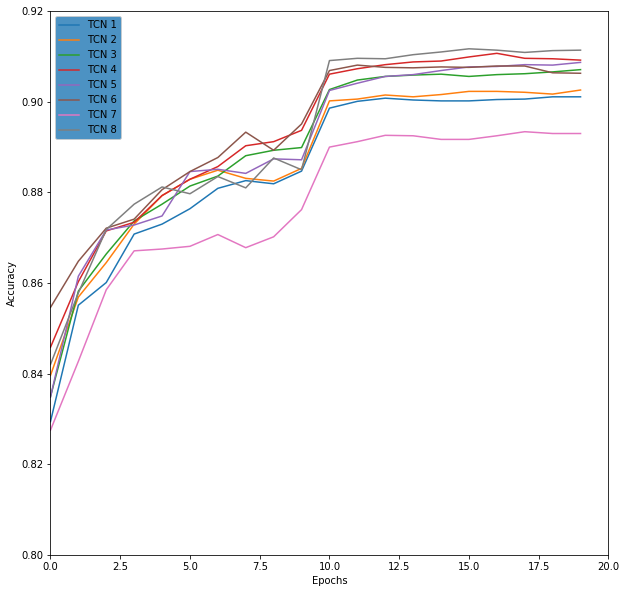

In [280]:
plotAccuracies(paper_scores, fsize=10, acc_score=0.88, xlabel='Epochs', 
               ylabel='Accuracy', axis=[0, 20, 0.80, 0.92],
                title='')

In [303]:
# paper_parameters = [paper_parameters[i] for i, p in enumerate(paper_scores) if p['accuracies'][-1] >= 0.88]
# print(len(paper_parameters))
for i, p in enumerate(paper_parameters):
    p['epochs'] = 20
len(paper_parameters)
# paper_parameters

50

In [ ]:
# def runListParams(list_parameters):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels = 1 # just one for the image
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes) # 10 classes for fashion-mnist
log_interval = 100
seed = 1111
torch.manual_seed(seed)
permutee = False
input_channels = 1
seq_length = int(784 / input_channels)
steps = 0
cuda = True
scores = []
# epochs = 15

for model_indx, parameters in enumerate(paper_parameters):
    print(parameters)
#     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
#     permute = permute.to(device)

    train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

    model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
    model = nn.DataParallel(model)
    model.to(device)
    steps = 0
    print("size of model => {0}".format(count_parameters(model)))
    lr = parameters['lr']
    optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
    accuracies_ = []
    train_losses_ = [[] for i in range(0, 20)]
#     print(train_losses_)
    test_losses_ = []
    file_name = './best_models/paper_tunning_second_ss_{0}.pt'.format(model_indx)

    for epoch in range(1, parameters['epochs']+1):
        trainTCN(epoch)
        test_losses_.append(testTCN())
        if epoch % 5 == 0: 
            print('Saving checkpoint for model.....')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses_,
                'test_losses': test_losses_,
                'accuracies': accuracies_,
                'curr_lr': lr,
            }, file_name)
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    torch.save(model.module.state_dict(), file_name)
    scores.append({
        'accuracies': accuracies_,
        'train_losses': train_losses_,
        'test_losses': test_losses_,
    })
    print('Saved as %s' % file_name) 
save_obj(scores, './best_models/paper_tunning_second_ss')

{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0018660497750821964, 'ksize': 10, 'levels': 8, 'optim': 'Adam', 'nhid': 27, 'epochs': 20}
size of model => 110818
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.088086	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.640378	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.543068	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.484166	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.447805	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.437949	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.408254	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.398374	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.392077	Steps: 706384

Test set: Average loss: 0.4328, Accuracy: 8407/10000 (84%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.375901	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.368269	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.369554	Steps: 971376
Tra

Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.153746	Steps: 9217488
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.152842	Steps: 9295888
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.151260	Steps: 9374288
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.144213	Steps: 9452688
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.137936	Steps: 9531088

Test set: Average loss: 0.2866, Accuracy: 9037/10000 (90%)

Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.147723	Steps: 9639280
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.139186	Steps: 9717680
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.151331	Steps: 9796080
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.149467	Steps: 9874480
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.148165	Steps: 9952880
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.146344	Steps: 10031280
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.146031	Steps: 10109680
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.139511	Steps: 10188080
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.133324	Steps: 10266480

Test set: A

Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.270973	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.257318	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.278668	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.280894	Steps: 3647952

Test set: Average loss: 0.3390, Accuracy: 8741/10000 (87%)

Saving checkpoint for model.....
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.262097	Steps: 3756144
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.254805	Steps: 3834544
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.270803	Steps: 3912944
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.253722	Steps: 3991344
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.260646	Steps: 4069744
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.256258	Steps: 4148144
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.245030	Steps: 4226544
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.262518	Steps: 4304944
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.267601	Steps: 4383344

Test set: Average loss: 0.3124, Accuracy: 8839/10000 (88%)

T


Test set: Average loss: 0.2736, Accuracy: 9107/10000 (91%)

Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.142484	Steps: 12580848
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.137731	Steps: 12659248
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.147910	Steps: 12737648
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.138572	Steps: 12816048
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.142646	Steps: 12894448
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.140796	Steps: 12972848
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.129390	Steps: 13051248
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.133138	Steps: 13129648
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.133064	Steps: 13208048

Test set: Average loss: 0.2758, Accuracy: 9107/10000 (91%)

Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.138470	Steps: 13316240
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.133952	Steps: 13394640
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.144071	Steps: 13473040
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.135519	Steps: 13551440
Train Epo

In [302]:
paper_scores = load_obj('./best_models/paper_tunning_second')
# paper_scores
# bestModel(paper_scores, paper_params)
len(paper_scores)

8

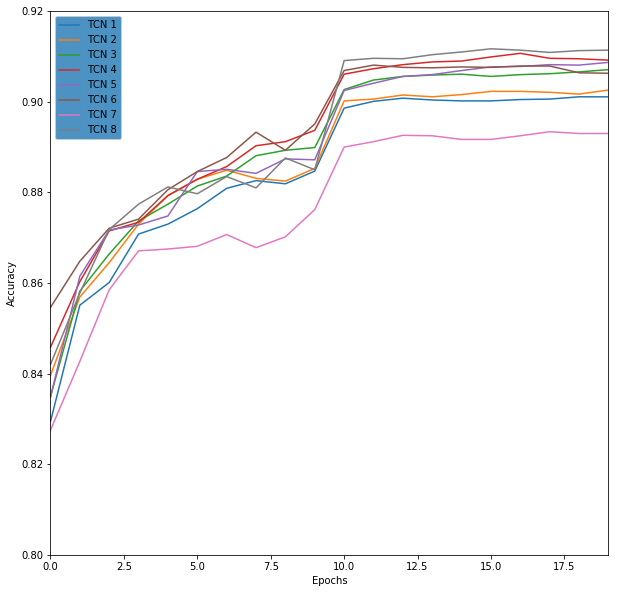

In [306]:
plotAccuracies(paper_scores, fsize=10, acc_score=0.88, xlabel='Epochs', 
               ylabel='Accuracy', axis=[0, 19, 0.80, 0.92],
                title='', p=paper_params)

In [299]:
# plotTrainLosses(paper_scores, fsize=20, 
#                 xlabel='Epochs', ylabel='Testing average loss', axis=[0, 20, 0, 2],
#                 title='')
len(paper_scores)

8

In [288]:
# bst = -1
# paper_parameters
# for score in paper_scores
# print(len(paper_scores))
# print(len(paper_parameters))

In [284]:
for i, score in enumerate(paper_scores):
    print(paper_parameters[i])
    print(score['accuracies'][-1])

{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0018660497750821964, 'ksize': 10, 'levels': 8, 'optim': 'Adam', 'nhid': 27, 'epochs': 20}
0.9011
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0015298719814126683, 'ksize': 6, 'levels': 10, 'optim': 'Adam', 'nhid': 28, 'epochs': 20}
0.9026
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00624651963066543, 'ksize': 11, 'levels': 7, 'optim': 'Adam', 'nhid': 29, 'epochs': 20}
0.9071
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00027339239229661686, 'ksize': 12, 'levels': 7, 'optim': 'Adam', 'nhid': 21, 'epochs': 20}
0.9092
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0009337282316908241, 'ksize': 6, 'levels': 9, 'optim': 'Adam', 'nhid': 20, 'epochs': 20}
0.9087
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00012179821087315272, 'ksize': 12, 'levels': 10, 'optim': 'Adam', 'nhid': 28, 'epochs': 20}
0.9063
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.003890087021499219,

In [ ]:
'./best_models/paper_tunning_second_7.pt'